# Installing and Importing

In [ ]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]


     |████████████████████████████████| 448 kB 3.8 MB/s 


In [ ]:
import sys
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import math
from sklearn.preprocessing import StandardScaler

# Utlity Function

In [ ]:
def query_environment(name):
    env = gym.make(name)
    spec = gym.spec(name)
    print(f"Action Space: {env.action_space.shape}")
    try:
        print(f"Low: {env.action_space.low}")
        print(f"High: {env.action_space.high}")
    except:
        pass
    print(f"Observation Space: {env.observation_space.shape}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")

In [ ]:
query_environment("BipedalWalker-v3")

Action Space: (4,)
Low: [-1. -1. -1. -1.]
High: [1. 1. 1. 1.]
Observation Space: (24,)
Max Episode Steps: 1600
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 300


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Hyperparameters

In [ ]:
"""hyperparam = {
    'gamma': 0.99,
    'lr':3e-4,
    "max_steps":1000,
    "max_episodes": 1000,
    "alpha_policy": 0.001,
    "alpha_state": 0.001,
    "trace_decay_policy": 0.8,
    "trace_decay_state": 0.8
}"""

hyperparam = {
    'gamma': 0.99,
    'lr':3e-4,
    "max_steps":10000,
    "max_episodes": 2000,
    "alpha_policy": 0.0005,
    "alpha_state": 0.001,
    "lambda_actor":0.8,
    "lambda_critic":0.8
}

# Networks

In [ ]:
class PolicyNetwork(nn.Module):

    def __init__(self, env, device):
        super(PolicyNetwork, self).__init__()

        self.input_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.device = device

        self.FCL_Policy = nn.Sequential(
            nn.Linear(self.input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions),
        )

    def forward(self, X):

        actions = self.FCL_Policy(X)
        action_probabilities = F.softmax(actions, dim=1)

        return action_probabilities

In [ ]:
class ValueNetwork(nn.Module):

    def __init__(self, env, device):
        super(ValueNetwork, self).__init__()

        self.input_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.device = device

        self.FCL_Value = nn.Sequential(
            nn.Linear(self.input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, X):
        state_value = self.FCL_Value(X)
        return state_value

# Agents

In [ ]:
class Agent:
    def __init__(self, environment, device, filepath=None, display_progress=True):
        self.environment = environment
        self.device = device
        self.filepath = filepath
        self.display_progress = display_progress
        self.display_freq = 50

        self.max_episodes = hyperparam['max_episodes']
        self.max_steps = hyperparam['max_steps']

        self.learning_rate = hyperparam['lr']
        self.discount_factor = hyperparam['gamma']
        self.stepsize_policy = hyperparam['alpha_policy']
        self.stepsize_value = hyperparam['alpha_state']
        self.lambda_actor = hyperparam['lambda_actor']
        self.lambda_critic = hyperparam['lambda_critic']

        self.Policy_Net = PolicyNetwork(self.environment, self.device).to(self.device)
        self.Value_Net = ValueNetwork(self.environment, self.device).to(self.device)
        self.policy_optimizer = optim.AdamW(params=self.Policy_Net.parameters(), lr=self.stepsize_policy)
        self.value_optimizer = optim.AdamW(params=self.Value_Net.parameters(), lr=self.stepsize_value)

        self.scores = []

    def get_action(self, network, state):

        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)

        action_probabilities = network(state)
        state = state.detach()

        action_dist = Categorical(action_probabilities)
        entropy = action_dist.entropy()
        action = action_dist.sample()

        #return action
        return action.item(), action_dist.log_prob(action), entropy

    def backpropagate(self, action_dist, state_val, new_state_val, reward, I, entropy):
        value_loss =  F.mse_loss(reward + self.discount_factor * new_state_val, state_val)
        value_loss *= I

        advantage = reward + self.discount_factor * new_state_val.item() - state_val.item()
        #policy_loss = -action_dist * advantage + entropy.mean().item()
        policy_loss = -action_dist * advantage
        policy_loss *= I

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

    def train(self):

        for episode in range(self.max_episodes):

            state = self.environment.reset()
            done = False
            I = 1
            score = 0

            for step in range(self.max_steps):

                action, action_dist, entropy = self.get_action(self.Policy_Net, state)
                new_state, reward, done, _ = self.environment.step(action)

                score += reward

                state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
                state_value = self.Value_Net(state_tensor)

                new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(self.device)
                new_state_value = self.Value_Net(new_state_tensor)

                """if done:
                    new_state_value = torch.tensor([0]).float().unsqueeze(0).to(self.device)"""

                self.backpropagate(action_dist, state_value, new_state_value, reward, I, entropy)

                if done:
                    break

                state = new_state
                I *= self.discount_factor

            self.scores.append(score)

            if self.display_progress and (episode + 1 ) % 10 == 0:
                print(f'Episode {episode + 1} scores {np.array(self.scores).mean()}')

            if (episode + 1) % self.display_freq == 0 and self.display_progress:

                scores = self.scores
                plt.plot(scores)
                plt.ylabel('score')
                plt.xlabel('episodes')
                plt.title('Training score of CartPole Actor-Critic TD(0)')

                reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
                y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
                plt.plot(y_pred)
                plt.show()

        self.environment.close()

    def learn(self):
        import time
        start_time = time.time()
        self.train()
        end_time = time.time()
        print(f'The algorithm has taken {end_time - start_time} to train itself!')

# Run

Episode 10 scores -363.9586871946073
Episode 20 scores -274.49932819753747
Episode 30 scores -225.49701176073071
Episode 40 scores -192.38136269997997
Episode 50 scores -164.84940337903944


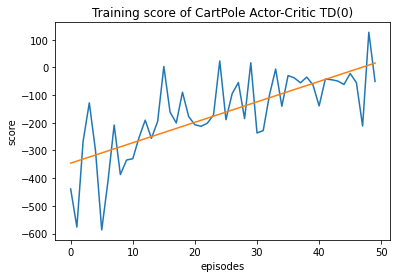

Episode 60 scores -156.04899778561264
Episode 70 scores -146.61067708810026
Episode 80 scores -131.52972065889898
Episode 90 scores -123.20411589940912
Episode 100 scores -115.5722729847838


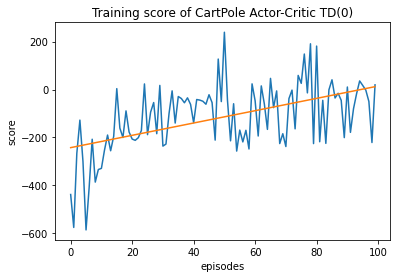

Episode 110 scores -104.23515574334154
Episode 120 scores -91.23867535087265
Episode 130 scores -85.93351050147247
Episode 140 scores -79.87020483506937
Episode 150 scores -65.54317234505052


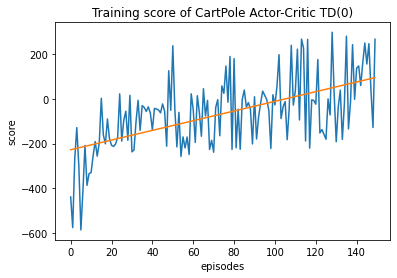

Episode 160 scores -63.99797687514532
Episode 170 scores -56.82653809755494
Episode 180 scores -52.53105984900945
Episode 190 scores -57.06811435783429
Episode 200 scores -69.80342057125397


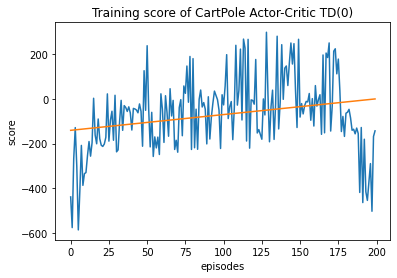

Episode 210 scores -78.72533767111963
Episode 220 scores -87.07175848529344
Episode 230 scores -97.2088000054996
Episode 240 scores -103.88448108661856
Episode 250 scores -112.9538817895219


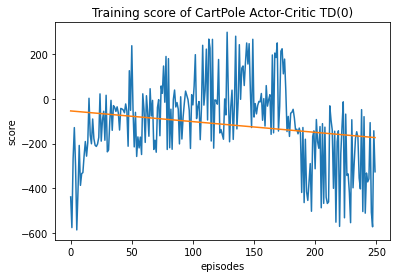

Episode 260 scores -121.52138785817854
Episode 270 scores -129.12103515420372
Episode 280 scores -134.26654818590433
Episode 290 scores -139.25593018683813
Episode 300 scores -140.85098851018694


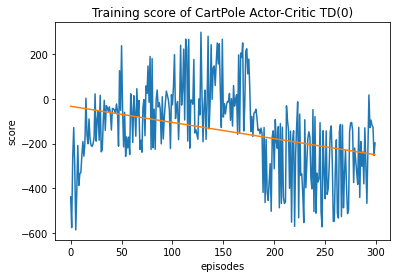

Episode 310 scores -144.85543522068508
Episode 320 scores -148.49306127969578
Episode 330 scores -148.24977036870027
Episode 340 scores -148.6589283321615
Episode 350 scores -148.41338813157


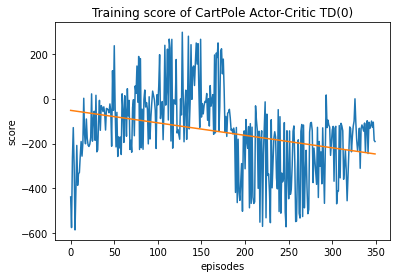

Episode 360 scores -148.23144826803656
Episode 370 scores -147.97426256813444
Episode 380 scores -147.20944444133397
Episode 390 scores -146.5672546956062
Episode 400 scores -145.79927095118205


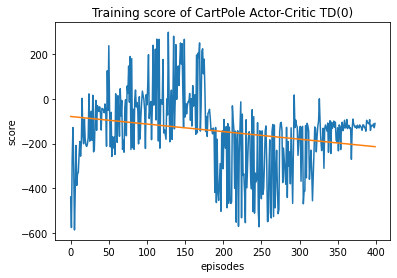

Episode 410 scores -144.58084300768573
Episode 420 scores -145.10708541052637
Episode 430 scores -142.93113111513992
Episode 440 scores -138.67021633303878
Episode 450 scores -134.03261993893042


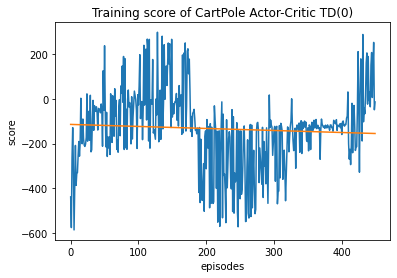

Episode 460 scores -131.8870413703676
Episode 470 scores -128.61789336950673
Episode 480 scores -128.5168464829106
Episode 490 scores -129.20035317791053
Episode 500 scores -127.11987247042259


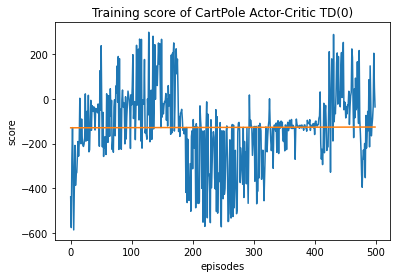

Episode 510 scores -126.45791589811695


KeyboardInterrupt: ignored

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

env = gym.make('LunarLander-v2')

Trainer = Agent(env, device)
Trainer.learn()

# Hyperparameters

In [ ]:
hyperparam = {
    'max_steps': 10000,
    'max_episodes': 1000,
    'discount_factor': 0.99,
    'alpha_actor': 1e-4,
    'alpha_critic': 1e-4,
    'lambda_actor': 0.8,
    'lambda_critic': 0.8
}

# Networks

In [ ]:
class Actor(nn.Module):

    def __init__(self, env, device):
        super(Actor, self).__init__()

        self.input_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.device = device

        self.FCL_Policy = nn.Sequential(
            nn.Linear(self.input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions),
        )

    def forward(self, X):

        actions = self.FCL_Policy(X)
        action_probabilities = F.softmax(actions, dim=1)

        return action_probabilities

In [ ]:
class Critic(nn.Module):

    def __init__(self, env, device):
        super(Critic, self).__init__()

        self.input_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.device = device

        self.FCL_Value = nn.Sequential(
            nn.Linear(self.input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, X):
        state_value = self.FCL_Value(X)
        return state_value

# Agents (Trace)

In [ ]:
class Agent:
    def __init__(self, environment, device, filepath=None, display_progress=True):
        self.environment = environment
        self.device = device
        self.filepath = filepath
        self.display_progress = display_progress
        self.display_freq = 50

        self.max_episodes = hyperparam['max_episodes']
        self.max_steps = hyperparam['max_steps']

        self.discount_factor = hyperparam['discount_factor']
        self.stepsize_actor = hyperparam['alpha_actor']
        self.stepsize_critic = hyperparam['alpha_critic']
        self.lambda_actor = hyperparam['lambda_actor']
        self.lambda_critic = hyperparam['lambda_critic']

        self.Actor_Net = Actor(self.environment, self.device).to(self.device)
        self.Critic_Net = Critic(self.environment, self.device).to(self.device)
        self.actor_optimizer = optim.Adam(params=self.Actor_Net.parameters(), lr=self.stepsize_actor)
        self.critic_optimizer = optim.Adam(params=self.Critic_Net.parameters(), lr=self.stepsize_critic)

        self.scores = []

    def get_action(self, network, state):

        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        state.requires_grad = True
        try:
            action_probabilities = network(state)
            state = state.detach()

            action_dist = Categorical(action_probabilities)
            action = action_dist.sample()
        except:
            print(action_probabilities, action_probabilities.size())

            assert 1 == 2

        #return action
        return action.item(), action_dist.log_prob(action)

    def count_param_num(self, model):
        pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        return pytorch_total_params

    def backpropagate(self, action_dist, state_val, new_state_val, reward, z_actor, z_critic, I):

        delta = reward + self.discount_factor * new_state_val.item() - state_val.item()

        self.Actor_Net.zero_grad()
        with torch.no_grad():
            for i, p in enumerate(self.Actor_Net.parameters()):
                new_p_val = p + self.stepsize_actor * delta * z_actor[i]
                p.copy_(new_p_val)

        self.Critic_Net.zero_grad()
        #update parameters with trace
        with torch.no_grad():
            for i, p in enumerate(self.Critic_Net.parameters()):
                new_val = p + self.stepsize_critic * delta * z_critic[i]
                p.copy_(new_val)

    def train(self):

        actor_num = self.count_param_num(self.Actor_Net)
        critic_num = self.count_param_num(self.Critic_Net)
        #print(actor_num, critic_num)

        for episode in range(self.max_episodes):

            state = self.environment.reset()
            done = False
            I = 1
            z_actor = []
            z_critic = []
            score = 0

            for step in range(self.max_steps):

                action, action_dist = self.get_action(self.Actor_Net, state)
                new_state, reward, done, _ = self.environment.step(action)

                score += reward

                state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
                state_value = self.Critic_Net(state_tensor)

                new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(self.device)
                new_state_value = self.Critic_Net(new_state_tensor)

                if done:
                    new_state_value = torch.tensor([0]).float().unsqueeze(0).to(self.device)

                self.Actor_Net.zero_grad()
                action_dist.backward()
                if not z_actor:
                    with torch.no_grad():
                        for p in self.Actor_Net.parameters():
                            trace = I * p.grad
                            z_actor.append(trace)
                else:
                    with torch.no_grad():
                        for i, p in enumerate(self.Actor_Net.parameters()):
                            z_actor[i] = z_actor[i] * self.lambda_actor * self.discount_factor + I * p.grad

                self.Critic_Net.zero_grad()
                state_value.backward()
                if not z_critic:
                    with torch.no_grad():
                        for p in self.Critic_Net.parameters():
                            #initialize trace
                            trace = I * p.grad
                            z_critic.append(trace)
                else:
                    with torch.no_grad():
                        for i, p in enumerate(self.Critic_Net.parameters()):
                            z_critic[i] = z_critic[i] * self.lambda_critic * self.discount_factor + I * p.grad


                self.backpropagate(action_dist, state_value, new_state_value, reward, z_actor, z_critic, I)

                if done:
                    break

                state = new_state
                I *= self.discount_factor

            self.scores.append(score)

            if self.display_progress and (episode + 1 ) % 5 == 0:
                print(f'Episode {episode + 1} scores {self.scores[-1]}')

            if (episode + 1) % self.display_freq == 0 and self.display_progress:

                scores = self.scores
                plt.plot(scores)
                plt.ylabel('score')
                plt.xlabel('episodes')
                plt.title(f'Training score of {self.environment} Actor-Critic with eligibility trace')

                reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
                y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
                plt.plot(y_pred)
                plt.show()

        self.environment.close()

    def learn(self):
        import time
        start_time = time.time()
        self.train()
        end_time = time.time()
        print(f'The algorithm has taken {end_time - start_time} to train itself!')

# Run (Trace)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
env = gym.make('LunarLander-v2')

Trainer = Agent(env, device)
Trainer.learn()

# Hyperparameters for Bipedal

In [ ]:
hyperparameters = {
    'lr_actor': 0.001,
    'lr_critic': 0.005,
    'discount_factor': 0.995,
    'entropy_beta': 1e-4,
    'max_episodes': 3000,
    'max_steps': 10000,
    'display_freq': 20,
    'log_freq': 5,
    'save_freq': 100

}

# New Utility Functions

In [ ]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def mish(self, input):
        return input * torch.tanh(F.softplus(input))

    def forward(self, input):
        return self.mish(input)

In [ ]:
# helper function to convert numpy arrays to tensors
def tensor_conversion(x, device):
    x = np.array(x) if not isinstance(x, np.ndarray) else x
    return torch.from_numpy(x).float().unsqueeze(0).to(device)

In [ ]:
def Scaler(x):
    m = x.mean(0, keepdim=True)
    s = x.std(0, unbiased=False, keepdim=True)
    x -= m
    x /= s

    return x

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
import sklearn
import sklearn.preprocessing

def fit_environment(env_name):
    state_space_samples = np.array(
        [env.observation_space.sample() for x in range(50000)])
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(state_space_samples)

    return scaler



# Networks (Continuous)

In [ ]:
class Actor(nn.Module):
    def __init__(self, env, device, activation=nn.ELU()):
        super(Actor, self).__init__()

        self.env = env
        self.device = device
        self.input_dim = env.observation_space.shape[0]
        self.output_dim = env.action_space.shape[0]
        self.hidden_size_1 = 512
        self.hidden_size_2 = 256
        self.activation_f = activation

        self.fcl = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_size_1),
            nn.Dropout(0.1),
            nn.LayerNorm(self.hidden_size_1),
            nn.ELU(),
            nn.Linear(self.hidden_size_1, self.hidden_size_2),
            nn.Dropout(0.1),
            nn.LayerNorm(self.hidden_size_2),
            nn.ELU(),
        )

        self.sigma2 = nn.Sequential(
            nn.Linear(self.hidden_size_2, self.output_dim),
            nn.Softplus(),
        )

        self.mu = nn.Sequential(
            nn.Linear(self.hidden_size_2, self.output_dim),
            nn.Tanh()
        )

    def forward(self, X):
        Y = self.fcl(X)
        return self.mu(Y), self.sigma2(Y)

    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)



In [ ]:
class Critic(nn.Module):
    def __init__(self, env, device, activation=nn.ELU()):
        super(Critic, self).__init__()

        self.env = env
        self.device = device
        self.input_dim = env.observation_space.shape[0]
        self.output_dim = env.action_space.shape[0]
        self.hidden_size_1 = 512
        self.hidden_size_2 = 256
        self.activation_f = activation

        self.fcl = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_size_1),
            nn.Dropout(0.1),
            nn.LayerNorm(self.hidden_size_1),
            nn.ReLU(),
            nn.Linear(self.hidden_size_1, self.hidden_size_2),
            nn.Dropout(0.1),
            nn.LayerNorm(self.hidden_size_2),
            nn.ReLU(),
            nn.Linear(self.hidden_size_2, 1)
        )

    def forward(self, X):
        return self.fcl(X)




# Agent (cont.)

In [ ]:
class Agent:
    def __init__(self, environment, device, filepath=None, display_progress=True):
        self.environment = environment
        self.device = device
        self.filepath = filepath
        self.display_progress = display_progress
        self.display_freq = hyperparameters['display_freq']
        self.log_freq = hyperparameters['log_freq']
        self.save_freq = hyperparameters['save_freq']

        self.max_episodes = hyperparameters['max_episodes']
        self.max_steps = hyperparameters['max_steps']

        self.learning_rate_actor = hyperparameters['lr_actor']
        self.learning_rate_critic = hyperparameters['lr_critic']
        self.discount_factor = hyperparameters['discount_factor']
        self.entropy_beta = hyperparameters['entropy_beta']

        self.Actor_Net = Actor(self.environment, self.device).to(self.device)
        self.Critic_Net = Critic(self.environment, self.device).to(self.device)
        self.actor_optimizer = optim.Adam(params=self.Actor_Net.parameters(), lr=self.learning_rate_actor)
        self.critic_optimizer = optim.Adam(params=self.Critic_Net.parameters(), lr=self.learning_rate_critic)

        self.scores = []

        self.Actor_Net.apply(init_weights)
        self.Critic_Net.apply(init_weights)

    def get_action(self, state):

        state_t = tensor_conversion(state, self.device)
        state_t.detach()

        mu_t, sigma2_t = self.Actor_Net(state_t)
        sigma_t = torch.sqrt(sigma2_t)
        sigma_t = torch.clamp(sigma_t, min=1e-5, max=1)

        actions_dist_t = torch.distributions.Normal(mu_t, sigma_t)
        actions_t = actions_dist_t.sample()

        actions_t = torch.clamp(actions_t,
                                min=self.environment.action_space.low[0],
                                max=self.environment.action_space.high[1])
        """actions_t = torch.clamp(actions_t,
                                min=self.environment.action_space.low[0])"""
        actions = actions_t.data.cpu().numpy().squeeze(0)

        return actions, actions_dist_t, sigma2_t


    def backpropagate(self, action, action_dist, state_value, new_state_value, reward, I, done):
        max_grad_norm = 0.5
        action = tensor_conversion(action, self.device)
        log_probability = action_dist.log_prob(action)
        target = reward + self.discount_factor * new_state_value * (1 - done)

        #entropy_loss = self.entropy_beta * (-(torch.log(2*math.pi*sigma2) + 2)/2).mean().item()

        critic_loss = F.mse_loss(target, state_value)
        critic_loss *= I
        critic_loss.to(self.device)

        advantage = reward + self.discount_factor * new_state_value.item() - state_value.item()
        #actor_loss = (-log_probability * advantage).mean() - self.entropy_beta* action_dist.entropy().mean()
        actor_loss = (-log_probability * advantage).mean()
        actor_loss *= I
        actor_loss.to(self.device)

        self.actor_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        #nn.utils.clip_grad_norm_([p for g in self.actor_optimizer.param_groups for p in g["params"]], max_grad_norm) # gradient clipping
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward(retain_graph=True)
        #nn.utils.clip_grad_norm_([p for g in self.critic_optimizer.param_groups for p in g["params"]], max_grad_norm)
        self.critic_optimizer.step()


    def train(self):

        for episode in range(self.max_episodes):

            state = self.environment.reset()
            done = False
            I = 1
            score = 0

            for step in range(self.max_steps):

                action, action_dist_t, sigma2_t = self.get_action(state)

                new_state, reward, done, _ = self.environment.step(action)

                score += reward

                state_t = tensor_conversion(state, self.device)
                state_value_t = self.Critic_Net(state_t)

                new_state_t = tensor_conversion(new_state, self.device)
                new_state_value_t = self.Critic_Net(new_state_t)

                """if done:
                    new_state_value_t = tensor_conversion([0], self.device)"""

                self.backpropagate(action, action_dist_t, state_value_t, new_state_value_t, reward, I, done)

                if done:
                    break

                state = new_state
                I *= self.discount_factor

            self.scores.append(score)

            if self.display_progress and (episode + 1 ) % 10 == 0:
                print(f'Episode {episode + 1} scores {np.array(self.scores).mean()}')


            if (episode + 1) % self.display_freq == 0 and self.display_progress:

                scores = self.scores
                plt.plot(scores)
                plt.ylabel('score')
                plt.xlabel('episodes')
                plt.title('Training score of Bipedal Walker')

                reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
                y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
                plt.plot(y_pred)
                plt.show()

        self.environment.close()

    def learn(self):
        import time
        start_time = time.time()
        self.train()
        end_time = time.time()
        print(f'The algorithm has taken {end_time - start_time} to train itself!')

# Bipedal Walker

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
env = gym.make('Pendulum-v0')

Trainer = Agent(env, device)
Trainer.learn()

# Utility Functions For DDPG

In [ ]:
from collections import deque
import random

class ReplayBuffer():
    def __init__(self, max_size):
        self.max_size = max_size
        self.replay_memory = deque([], maxlen=self.max_size)

    def append(self, state, action, reward, next_state, done):
        self.replay_memory.append((state, action, reward, next_state, done))

    def sample_batch(self, batch_size=32):
        assert len(self.replay_memory) >= 32, "Length of Replay Memory is too short"
        assert batch_size > 0, "Argument Batch size must be greater than 0"

        return zip(*random.sample(self.replay_memory, k = batch_size))

    def __len__(self):
        return len(self.replay_memory)

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

In [ ]:
def tensor_conversion(x, device):
    x = np.array(x) if not isinstance(x, np.ndarray) else x
    return torch.from_numpy(x).float().unsqueeze(0).to(device)

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Networks DDPG

In [ ]:
architecture = {
    'hs_1': 128,
    'hs_2': 128,
    'lr_actor': 1e-4,
    'lr_critic': 1e-3,
    'gamma': 0.99,
    'tau': 0.01,
    'max_episodes': 3000,
    'max_steps': 2500,
    'target_update_freq': 25,
    'batch_size': 100000,
    'minibatch_size': 128,
    'batch_before_update': 10000,
    'display_freq': 20
}

In [ ]:
class Actor(nn.Module):
    def __init__(self, env, device):
        super(Actor, self).__init__()

        self.env = env
        self.device = device
        self.input_dim = env.observation_space.shape[0]
        self.output_dim = env.action_space.shape[0]
        self.hidden_size_1 = architecture['hs_1']
        self.hidden_size_2 = architecture['hs_2']

        self.fcl = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_size_1),
            nn.ReLU(),
            #nn.LayerNorm(self.hidden_size_1),
            nn.Linear(self.hidden_size_1, self.hidden_size_2),
            nn.ReLU(),
            #nn.LayerNorm(self.hidden_size_2),
            nn.Linear(self.hidden_size_2, self.output_dim),
            nn.Tanh()
        )

        self.optimizer = optim.Adam(self.parameters(), lr=architecture['lr_actor'])

        self.xavier(self.fcl)

    def forward(self, X):
        Y = self.fcl(X)
        return Y

    def xavier(self, net):
        net.apply(init_weights)


In [ ]:
class Critic(nn.Module):
    def __init__(self, env, device):
        super(Critic, self).__init__()

        self.env = env
        self.device = device
        self.input_dim = env.observation_space.shape[0] + env.action_space.shape[0]
        self.output_dim = 1
        self.hidden_size_1 = architecture['hs_1']
        self.hidden_size_2 = architecture['hs_2']

        self.fcl = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_size_1),
            nn.ReLU(),
            #nn.LayerNorm(self.hidden_size_1),
            nn.Linear(self.hidden_size_1, self.hidden_size_2),
            nn.ReLU(),
            #nn.LayerNorm(self.hidden_size_2),
            nn.Linear(self.hidden_size_2, self.output_dim),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=architecture['lr_critic'])
        self.xavier(self.fcl)

    def forward(self, state, action):
        X = torch.cat([state, action], 2).squeeze(0)
        return self.fcl(X)

    def xavier(self, net):
        net.apply(init_weights)

In [ ]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

# DDPG Agent


In [ ]:
class DDPGAgent:
    def __init__(self, environment, device, filepath=None, display_progress=True):

        self.environment = environment
        self.device = device
        self.filepath = filepath
        self.display_progress = display_progress
        self.display_freq = architecture['display_freq']

        self.max_episodes = architecture['max_episodes']
        self.max_steps = architecture['max_steps']
        self.target_update_freq = architecture['target_update_freq']

        self.discount_factor = architecture['gamma']
        self.tau = architecture['tau']
        self.minibatch_size = architecture['minibatch_size']
        self.batch_size = architecture['batch_size']
        self.batch_before_update = architecture['batch_before_update']

        self.replay_memory = ReplayBuffer(max_size=self.batch_size)

        self.Noise = OUNoise(self.environment.action_space, max_sigma=0.3, min_sigma=0.01, decay_period=self.max_steps)

        self.Actor_Net = Actor(self.environment, self.device).to(self.device)
        self.Critic_Net = Critic(self.environment, self.device).to(self.device)
        self.ActorT_Net = Actor(self.environment, self.device).to(self.device)
        self.CriticT_Net = Critic(self.environment, self.device).to(self.device)

        for target_param, param in zip(self.ActorT_Net.parameters(), self.Actor_Net.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.CriticT_Net.parameters(), self.Critic_Net.parameters()):
            target_param.data.copy_(param.data)

        self.scores = []


    def get_action(self, state):
        with torch.no_grad():
            states_t = tensor_conversion(state, self.device)
            action_t = self.Actor_Net(states_t)
            action = action_t.detach().data.cpu().numpy().squeeze(0)
        return action

    def update_network(self):
        (states, actions, rewards, next_states, dones) = self.replay_memory.sample_batch(self.minibatch_size)
        states_t = tensor_conversion(states, self.device)
        actions_t = tensor_conversion(actions, self.device)
        rewards_t = tensor_conversion(rewards, self.device).squeeze(0)
        next_states_t = tensor_conversion(next_states, self.device)
        dones_t = tensor_conversion(dones, self.device).squeeze(0)


        qvals_t = self.Critic_Net(states_t, actions_t).squeeze(1)
        next_qvals_t = self.CriticT_Net(next_states_t, self.ActorT_Net(next_states_t).detach()).squeeze(1)
        y_t = rewards_t + self.discount_factor * (1 - dones_t) * next_qvals_t
        y_t = y_t.squeeze(0)
        critic_loss = F.mse_loss(qvals_t, y_t)

        policy_loss = -self.Critic_Net.forward(states_t, self.Actor_Net(states_t)).mean()

        self.Actor_Net.optimizer.zero_grad()
        policy_loss.backward()
        self.Actor_Net.optimizer.step()

        self.Critic_Net.optimizer.zero_grad()
        critic_loss.backward()
        self.Critic_Net.optimizer.step()

        for target_param, param in zip(self.ActorT_Net.parameters(), self.Actor_Net.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.CriticT_Net.parameters(), self.Critic_Net.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))


    def train(self):

        for episode in range(self.max_episodes):
            state = self.environment.reset()
            episodic_reward = 0
            self.Noise.reset()

            for step in range(self.max_steps):
                action = self.get_action(state)
                action = self.Noise.get_action(action, step)
                next_state, reward, done, _ = self.environment.step(action)
                self.replay_memory.append(state, action, reward, next_state, done)

                if len(self.replay_memory) > self.minibatch_size:
                    self.update_network()

                episodic_reward += reward
                state = next_state

                if done:
                    break


            self.scores.append(episodic_reward)

            if self.display_progress and (episode + 1 ) % 10 == 0:
                print(f'Episode {episode + 1} scores {np.array(self.scores).mean()}')

            if (episode + 1) % self.display_freq == 0 and self.display_progress:

                scores = self.scores
                plt.plot(scores)
                plt.ylabel('score')
                plt.xlabel('episodes')
                plt.title('Training score of Bipedal Walker')

                reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
                y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
                plt.plot(y_pred)
                plt.show()

        self.environment.close()

    def learn(self):
        import time
        start_time = time.time()
        self.train()
        end_time = time.time()
        print(f'The algorithm has taken {end_time - start_time} to train itself!')

# DDPG Run

cuda


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 10 scores -135.0933713196522
Episode 20 scores -126.9304026200113


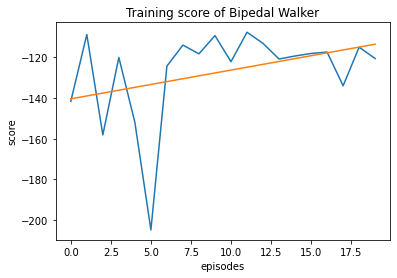

Episode 30 scores -123.55575826518368
Episode 40 scores -120.92916893087508


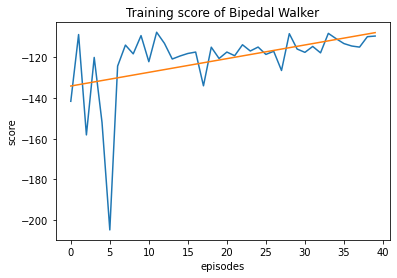

Episode 50 scores -119.44258019959378
Episode 60 scores -118.22137970057443


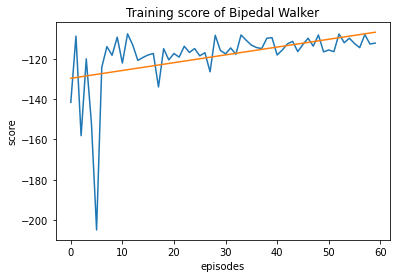

Episode 70 scores -117.62300953718578
Episode 80 scores -117.56204062208303


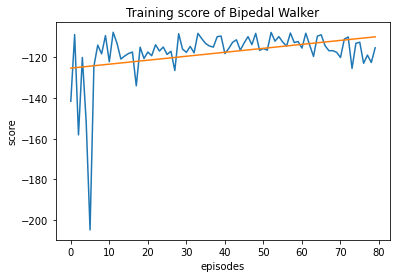

KeyboardInterrupt: ignored

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
env = gym.make('BipedalWalker-v3')

Trainer = DDPGAgent(env, device)
Trainer.learn()

# Not Mine

In [ ]:
import numpy as np
import gym
from collections import deque
import random

# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)


# https://github.com/openai/gym/blob/master/gym/core.py
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)


class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
from torch.autograd import Variable

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

In [ ]:
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn

class DDPGagent:
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)

    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action

    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        # Critic loss
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()

        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

In [ ]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = NormalizedEnv(gym.make("Pendulum-v1"))

agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 128
rewards = []
avg_rewards = []

for episode in range(50):
    state = env.reset()
    noise.reset()
    episode_reward = 0

    for step in range(500):
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        new_state, reward, done, _ = env.step(action)
        agent.memory.push(state, action, reward, new_state, done)

        if len(agent.memory) > batch_size:
            agent.update(batch_size)

        state = new_state
        episode_reward += reward

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

DeprecatedEnv: ignored

# TD3 (Util)

In [ ]:
from collections import deque
import random

class ReplayBuffer():
    def __init__(self, max_size):
        self.max_size = max_size
        self.replay_memory = deque([], maxlen=self.max_size)

    def append(self, state, action, reward, next_state, done):
        self.replay_memory.append((state, action, reward, next_state, done))

    def sample_batch(self, batch_size=32):
        assert len(self.replay_memory) >= 32, "Length of Replay Memory is too short"
        assert batch_size > 0, "Argument Batch size must be greater than 0"

        return zip(*random.sample(self.replay_memory, k = batch_size))

    def __len__(self):
        return len(self.replay_memory)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def tensor_conversion(x, device):
    x = np.array(x) if not isinstance(x, np.ndarray) else x
    return torch.from_numpy(x).float().unsqueeze(0).to(device)

# TD3 Networks

In [ ]:
architecture = {
    'hs_1': 512,
    'hs_2': 512,
    'lr_actor': 2e-4,
    'lr_critic': 2e-4,
    'gamma': 0.999,
    'tau': 0.005,
    'exploration_noise': 0.1,
    'actor_noise': 0.2,
    'noise_clip': 0.5,
    'max_episodes': 2000,
    'max_steps': 1600,
    'actor_update_freq': 2,
    'batch_size': 100000,
    'minibatch_size': 512,
    'start_steps': 50,
    'display_freq': 20
}

In [ ]:
class Actor(nn.Module):
    def __init__(self, env, device):
        super(Actor, self).__init__()

        self.env = env
        self.device = device
        self.input_dim = env.observation_space.shape[0]
        self.output_dim = env.action_space.shape[0]
        self.hidden_size_1 = architecture['hs_1']
        self.hidden_size_2 = architecture['hs_2']

        self.fcl = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_size_1),
            nn.ReLU(),
            #nn.LayerNorm(self.hidden_size_1),
            nn.Linear(self.hidden_size_1, self.hidden_size_2),
            nn.ReLU(),
            #nn.LayerNorm(self.hidden_size_2),
            nn.Linear(self.hidden_size_2, self.output_dim),
            nn.Tanh()
        )

        self.optimizer = optim.Adam(self.parameters(), lr=architecture['lr_actor'])

        self.xavier(self.fcl)

    def forward(self, X):
        Y = self.fcl(X)
        return Y

    def xavier(self, net):
        net.apply(init_weights)

In [ ]:
class Critic(nn.Module):
    def __init__(self, env, device):
        super(Critic, self).__init__()

        self.env = env
        self.device = device
        self.input_dim = env.observation_space.shape[0] + env.action_space.shape[0]
        self.output_dim = 1
        self.hidden_size_1 = architecture['hs_1']
        self.hidden_size_2 = architecture['hs_2']

        self.fcl = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_size_1),
            nn.ReLU(),
            #nn.LayerNorm(self.hidden_size_1),
            nn.Linear(self.hidden_size_1, self.hidden_size_2),
            nn.ReLU(),
            #nn.LayerNorm(self.hidden_size_2),
            nn.Linear(self.hidden_size_2, self.output_dim),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=architecture['lr_critic'])
        self.xavier(self.fcl)

    def forward(self, state, action):
        X = torch.cat([state, action], 2).squeeze(0)
        return self.fcl(X)

    def xavier(self, net):
        net.apply(init_weights)

In [ ]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

# TD3 Agent

In [ ]:
class TD3Agent:
    def __init__(self, environment, device, filepath=None, display_progress=True):

        self.environment = environment
        self.device = device
        self.filepath = filepath
        self.display_progress = display_progress
        self.display_freq = architecture['display_freq']

        self.max_episodes = architecture['max_episodes']
        self.max_steps = architecture['max_steps']
        self.actor_update_freq = architecture['actor_update_freq']
        self.start_steps = architecture['start_steps']

        self.discount_factor = architecture['gamma']
        self.tau = architecture['tau']
        self.minibatch_size = architecture['minibatch_size']
        self.batch_size = architecture['batch_size']
        self.exploration_noise = architecture['exploration_noise']
        self.actor_noise = architecture['actor_noise']
        self.noise_clip = architecture['noise_clip']

        self.replay_memory = ReplayBuffer(max_size=self.batch_size)

        self.Noise = OUNoise(self.environment.action_space, max_sigma=0.3, min_sigma=0.01, decay_period=self.max_steps)

        self.Actor_Net = Actor(self.environment, self.device).to(self.device)
        self.Critic1_Net = Critic(self.environment, self.device).to(self.device)
        self.Critic2_Net = Critic(self.environment, self.device).to(self.device)

        self.Actor_Net_optimizer = optim.Adam(self.Actor_Net.parameters(), lr=architecture['lr_actor'])
        self.Critic1_Net_optimizer = optim.Adam(self.Critic1_Net.parameters(), lr=architecture['lr_critic'])
        self.Critic2_Net_optimizer = optim.Adam(self.Critic2_Net.parameters(), lr=architecture['lr_critic'])

        self.ActorT_Net = Actor(self.environment, self.device).to(self.device)
        self.Critic1T_Net = Critic(self.environment, self.device).to(self.device)
        self.Critic2T_Net = Critic(self.environment, self.device).to(self.device)


        for target_param, param in zip(self.ActorT_Net.parameters(), self.Actor_Net.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.Critic1T_Net.parameters(), self.Critic1_Net.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.Critic2T_Net.parameters(), self.Critic2_Net.parameters()):
            target_param.data.copy_(param.data)
        self.scores = []


    def get_action(self, state):
        with torch.no_grad():
            states_t = tensor_conversion(state, self.device)
            action_t = self.Actor_Net(states_t)
            action = action_t.detach().data.cpu().numpy().squeeze(0)
        return action

    def update_network(self, episode):
        (states, actions, rewards, next_states, dones) = self.replay_memory.sample_batch(self.minibatch_size)
        states_t = tensor_conversion(states, self.device)
        actions_t = tensor_conversion(actions, self.device)
        rewards_t = tensor_conversion(rewards, self.device).squeeze(0)
        next_states_t = tensor_conversion(next_states, self.device)
        dones_t = tensor_conversion(dones, self.device).squeeze(0)

        noise_t = tensor_conversion(actions, self.device).data.normal_(0, self.actor_noise).to(self.device)
        noise_t = torch.clamp(noise_t, -self.noise_clip, self.noise_clip)

        qvals_1_t = self.Critic1_Net(states_t, actions_t).squeeze(1)
        qvals_2_t = self.Critic2_Net(states_t, actions_t).squeeze(1)

        next_action_t = (self.ActorT_Net(next_states_t).detach() + noise_t).to(self.device)
        next_action_t = torch.clamp(next_action_t, self.environment.action_space.low[0], self.environment.action_space.high[0])

        next_qvals_1_t = self.Critic1T_Net(next_states_t, next_action_t).squeeze(1)
        next_qvals_2_t = self.Critic2T_Net(next_states_t, next_action_t).squeeze(1)
        next_qvals_t = torch.min(next_qvals_1_t, next_qvals_2_t)

        y_t = rewards_t + self.discount_factor * (1 - dones_t) * next_qvals_t
        y_t = y_t.squeeze(0).detach()

        critic_1_loss = F.mse_loss(qvals_1_t, y_t).to(self.device)
        critic_2_loss = F.mse_loss(qvals_2_t, y_t).to(self.device)

        self.Critic1_Net_optimizer.zero_grad()
        critic_1_loss.backward(retain_graph=True)
        self.Critic1_Net_optimizer.step()

        self.Critic2_Net_optimizer.zero_grad()
        critic_2_loss.backward(retain_graph=True)
        self.Critic2_Net_optimizer.step()

        if episode % self.actor_update_freq == 0:

            policy_loss = -self.Critic1_Net.forward(states_t, self.Actor_Net(states_t)).mean()
            self.Actor_Net_optimizer.zero_grad()
            policy_loss.backward(retain_graph=True)
            self.Actor_Net_optimizer.step()

            for target_param, param in zip(self.ActorT_Net.parameters(), self.Actor_Net.parameters()):
                target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

            for target_param, param in zip(self.Critic1T_Net.parameters(), self.Critic1_Net.parameters()):
                target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

            for target_param, param in zip(self.Critic2T_Net.parameters(), self.Critic2_Net.parameters()):
                target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))


    def train(self):

        for episode in range(self.max_episodes):
            state = self.environment.reset()
            episodic_reward = 0
            self.Noise.reset()

            for step in range(self.max_steps):
                action = self.get_action(state)
                action = self.Noise.get_action(action, step)
                next_state, reward, done, _ = self.environment.step(action)
                self.replay_memory.append(state, action, reward, next_state, done)

                if len(self.replay_memory) > self.minibatch_size:
                    self.update_network(episode)

                episodic_reward += reward
                state = next_state

                if done:
                    break

            self.scores.append(episodic_reward)

            if self.display_progress and (episode + 1 ) % 10 == 0:
                print(f'Episode {episode + 1} scores {np.array(self.scores[-20:-1]).mean()}')

            if (episode + 1) % self.display_freq == 0 and self.display_progress:

                scores = self.scores
                plt.plot(scores)
                plt.ylabel('score')
                plt.xlabel('episodes')
                plt.title('Training score of Bipedal Walker')

                reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
                y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
                plt.plot(y_pred)
                plt.show()

            """if episode > 200 and np.array(self.scores[-20:-1]).mean() < -100:
                break"""

        self.environment.close()

    def learn(self):
        import time
        start_time = time.time()
        self.train()
        end_time = time.time()
        print(f'The algorithm has taken {end_time - start_time} to train itself!')

# TD3 Run

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


cuda


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 10 scores -117.14740445246288
Episode 20 scores -116.54702696886244


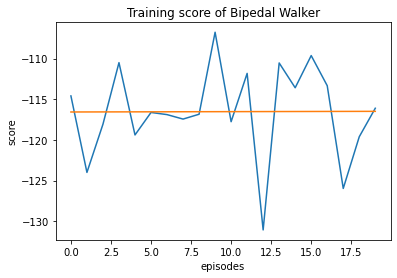

Episode 30 scores -115.56084782557637
Episode 40 scores -117.38980459116227


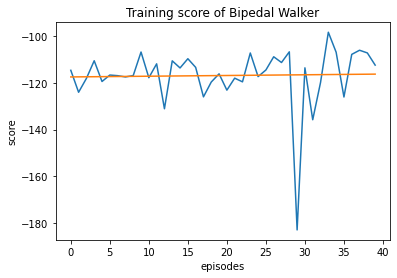

Episode 50 scores -116.68710962362282
Episode 60 scores -119.4278394771623


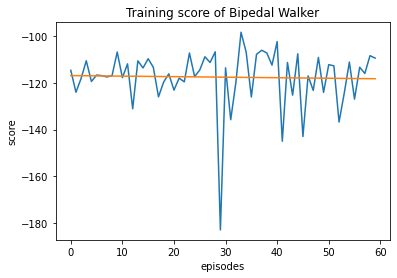

Episode 70 scores -114.81857392088607
Episode 80 scores -113.44983477989105


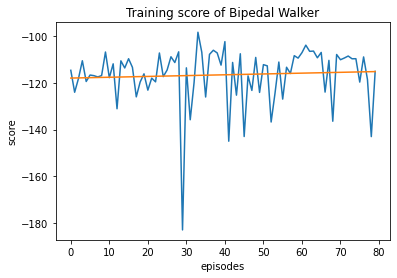

Episode 90 scores -118.19294392071754
Episode 100 scores -115.4943787097271


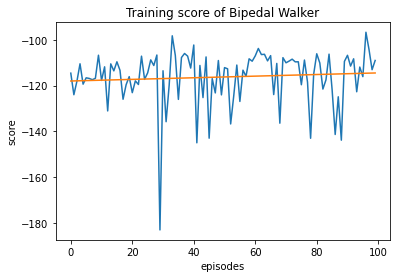

Episode 110 scores -112.3978749450581
Episode 120 scores -115.62450290807017


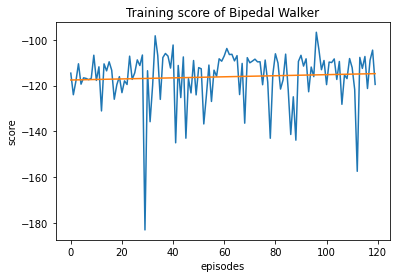

Episode 130 scores -114.75030744776272
Episode 140 scores -115.85106097389139


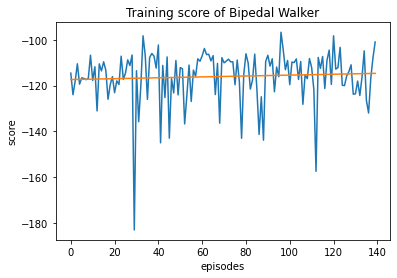

Episode 150 scores -117.5550879616125
Episode 160 scores -120.53007996092006


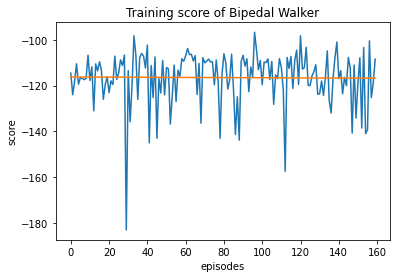

Episode 170 scores -115.76905820488757
Episode 180 scores -108.94358549694688


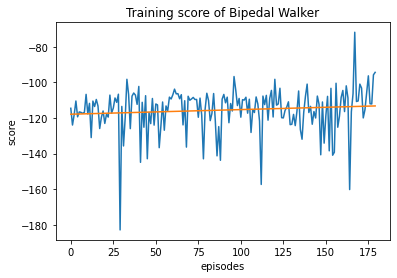

Episode 190 scores -104.31145016185486
Episode 200 scores -108.24075470193422


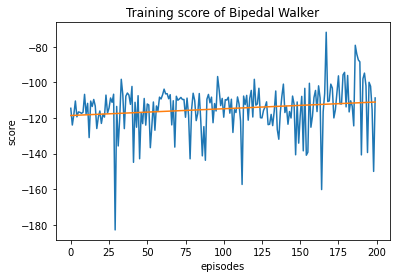

Episode 210 scores -114.08744585060221
Episode 220 scores -103.57130334351231


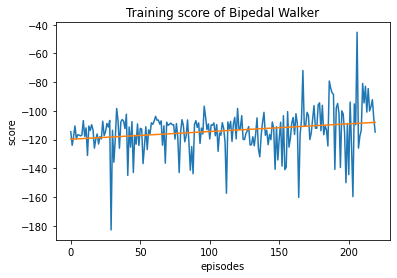

Episode 230 scores -97.14363532016587
Episode 240 scores -98.6004583879308


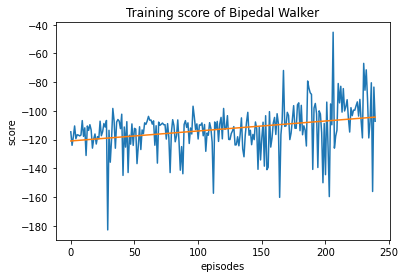

Episode 250 scores -94.94833805488473
Episode 260 scores -95.99757291781441


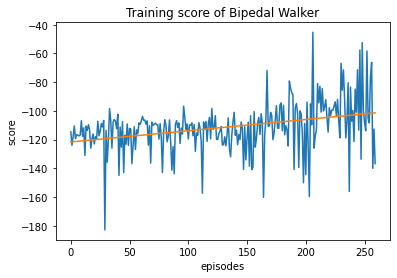

Episode 270 scores -106.17859150840465
Episode 280 scores -108.22907142123607


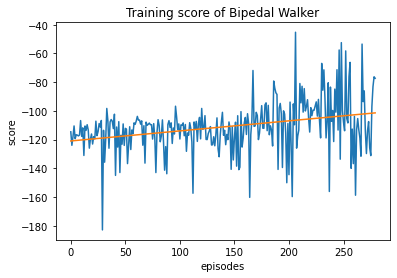

Episode 290 scores -105.46342321524806
Episode 300 scores -104.49980456511844


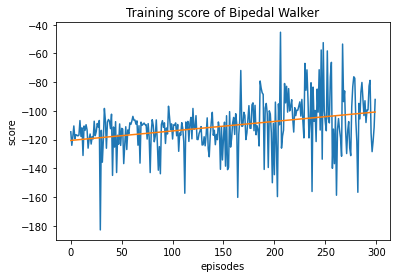

Episode 310 scores -92.09928203684923
Episode 320 scores -86.16568791594035


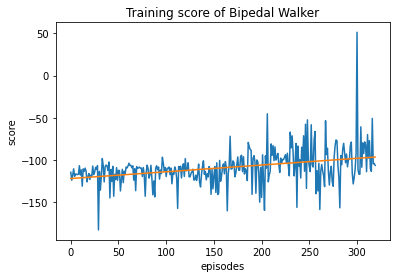

Episode 330 scores -94.48331954311236
Episode 340 scores -91.89825775988238


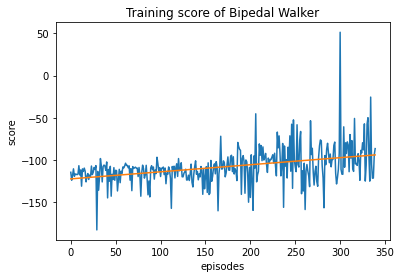

Episode 350 scores -88.23189922073118
Episode 360 scores -89.23409578487951


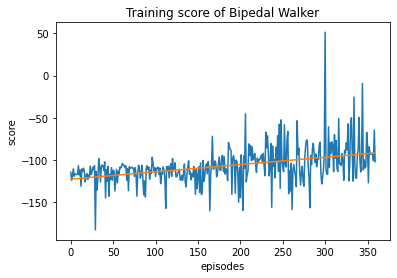

Episode 370 scores -11.242609398928964
Episode 380 scores 46.35024526043949


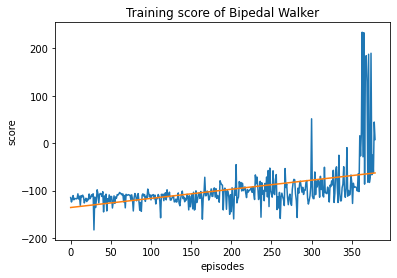

Episode 390 scores -14.150169718271304
Episode 400 scores -34.00789381796835


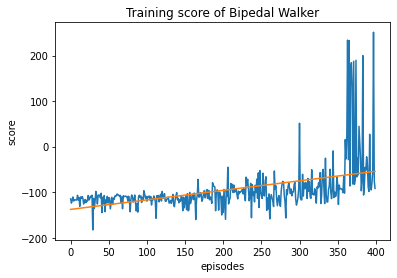

Episode 410 scores -9.09608863797196
Episode 420 scores 12.915361642887705


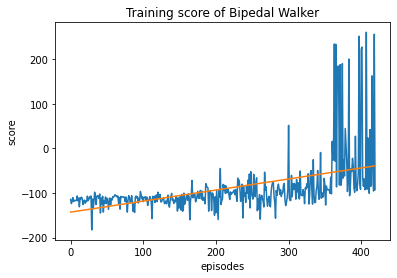

Episode 430 scores -9.859203828159236
Episode 440 scores -14.889956158330248


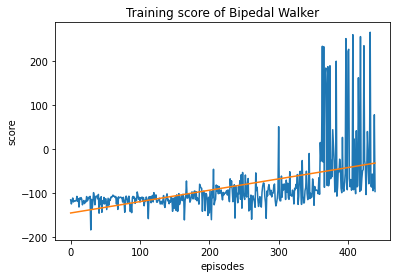

Episode 450 scores 38.45036718787746
Episode 460 scores 61.86617260324526


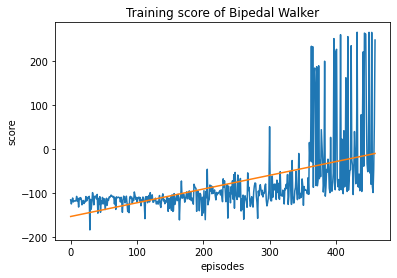

Episode 470 scores 6.3401013274966305
Episode 480 scores 4.477890081599502


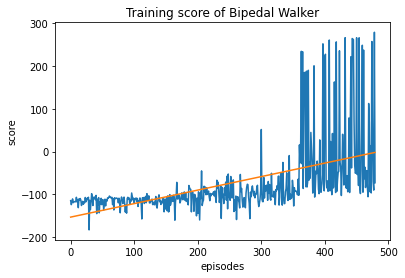

Episode 490 scores -18.048156945653755
Episode 500 scores -49.10608820595389


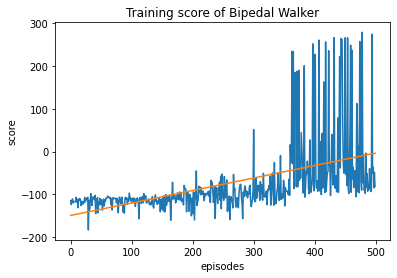

Episode 510 scores -4.038994653973484
Episode 520 scores -0.06719244524891964


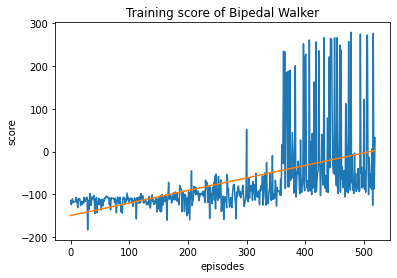

Episode 530 scores -5.807613389037527
Episode 540 scores -31.770006817475466


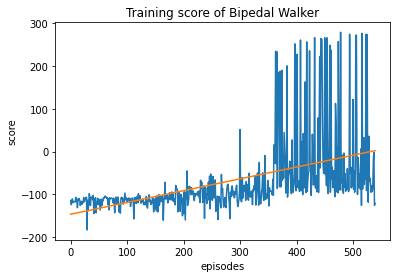

Episode 550 scores -94.44731098180375
Episode 560 scores -98.11021309866037


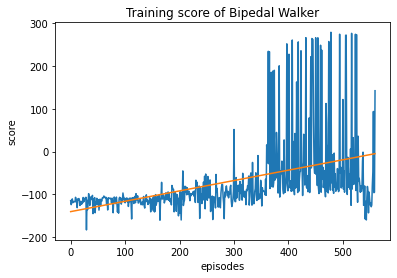

Episode 570 scores -4.637821891043522
Episode 580 scores 18.619643595473697


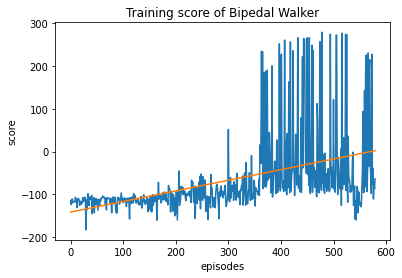

Episode 590 scores -17.780058945850413
Episode 600 scores -12.460004756645526


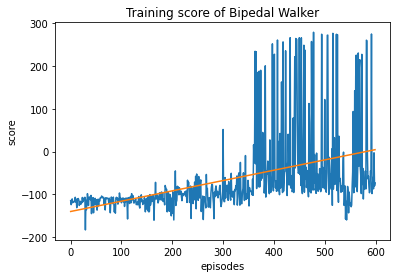

Episode 610 scores -18.444538566214536
Episode 620 scores -26.698605983053902


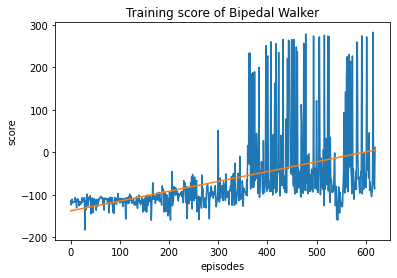

Episode 630 scores -37.74472302745956
Episode 640 scores -31.234446471742697


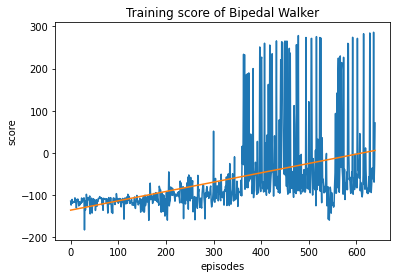

Episode 650 scores -40.49724728459085
Episode 660 scores -27.839380659079815


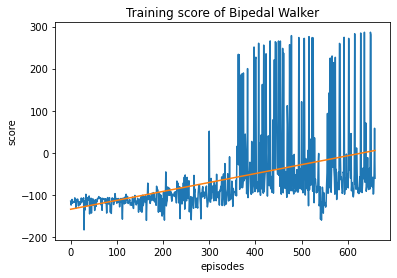

Episode 670 scores -14.940357070522234
Episode 680 scores -45.616387611037226


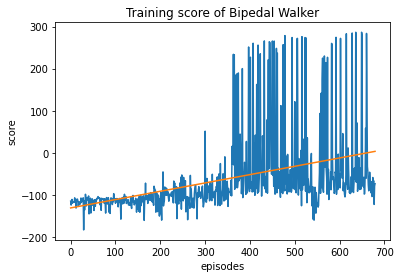

Episode 690 scores -55.3988606974094
Episode 700 scores -49.231487487490554


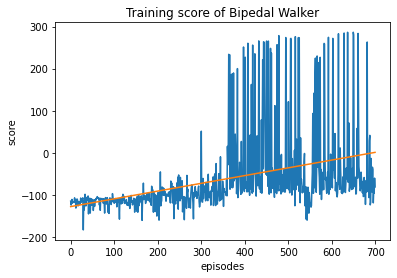

Episode 710 scores -76.5864683269362
Episode 720 scores -75.04085606414755


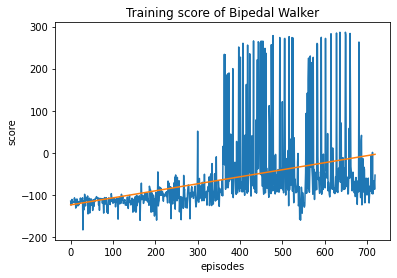

Episode 730 scores -25.134421247990847
Episode 740 scores -5.364234232248955


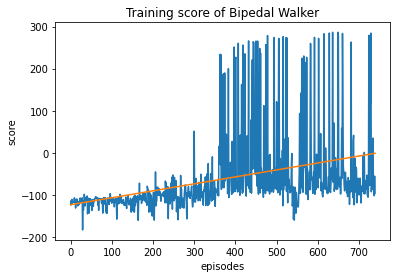

Episode 750 scores -48.869851137516314
Episode 760 scores -42.40651015258934


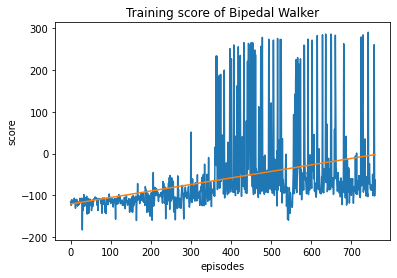

Episode 770 scores -63.64362066067705
Episode 780 scores -78.26299848734472


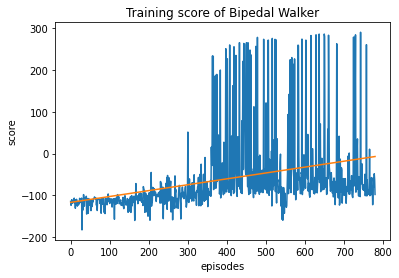

Episode 790 scores -32.81585554558609
Episode 800 scores -32.41605293880555


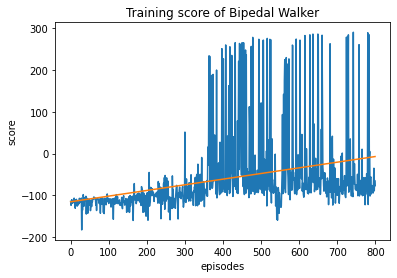

Episode 810 scores -71.27425567551619
Episode 820 scores -49.675023324743854


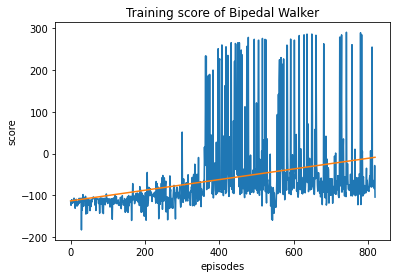

Episode 830 scores -41.40517065258278
Episode 840 scores -69.2194538762864


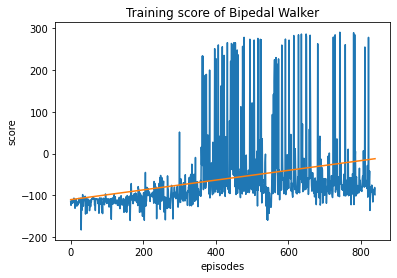

Episode 850 scores -87.79450789561675
Episode 860 scores -72.53526633721755


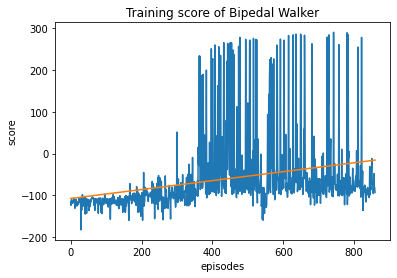

Episode 870 scores -73.88501008090843
Episode 880 scores -77.84399993975894


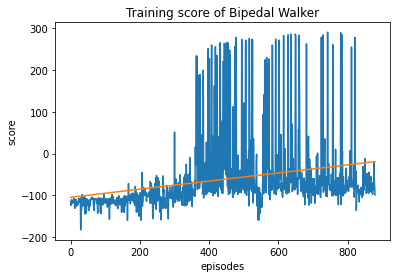

Episode 890 scores -77.17461414846953
Episode 900 scores -59.005706062858735


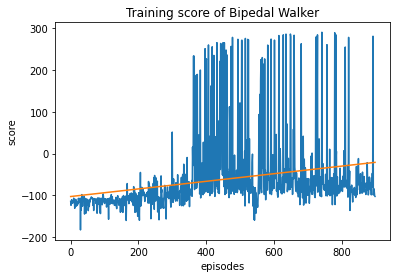

Episode 910 scores -61.90847823920407
Episode 920 scores -59.92516646339319


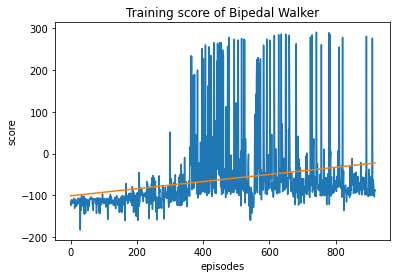

Episode 930 scores -60.65011925758185
Episode 940 scores -67.68739564537127


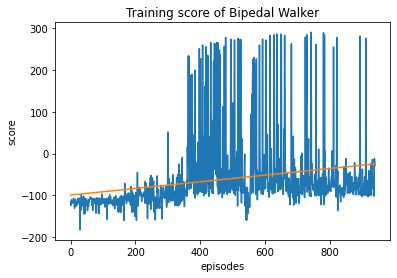

Episode 950 scores -64.79881712064388
Episode 960 scores -76.40386493954745


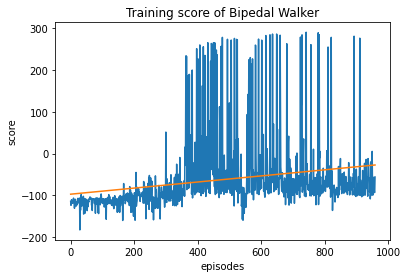

Episode 970 scores -81.26222253367197
Episode 980 scores -86.07741567554964


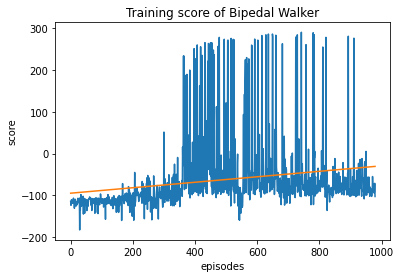

Episode 990 scores -84.88809531253847
Episode 1000 scores -73.26853253992584


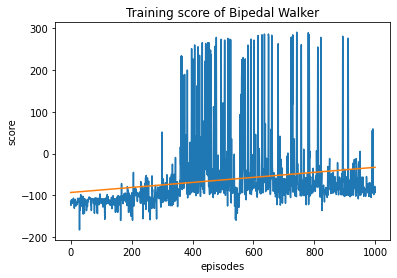

Episode 1010 scores -67.76853382885433
Episode 1020 scores -78.68366554561896


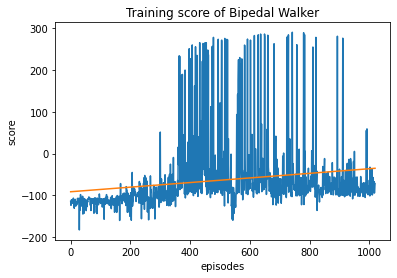

Episode 1030 scores -85.71990529804869
Episode 1040 scores -84.8883713042186


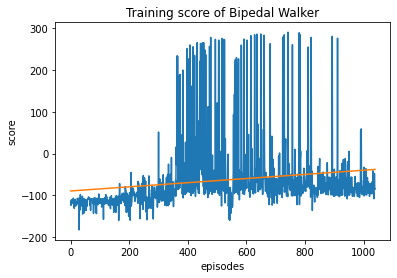

Episode 1050 scores -79.96290665823217
Episode 1060 scores -86.08128526289042


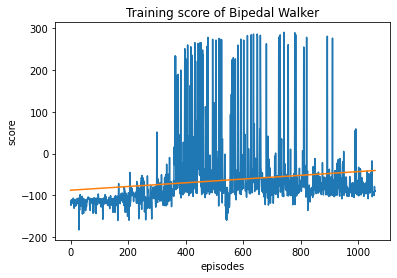

Episode 1070 scores -82.61069338802795
Episode 1080 scores -76.97633636844223


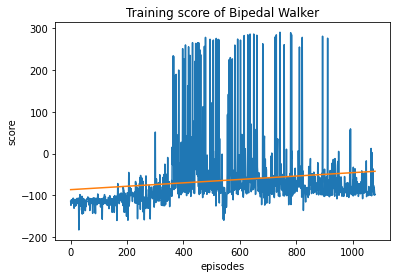

Episode 1090 scores -87.80733195183932
Episode 1100 scores -84.56211581756453


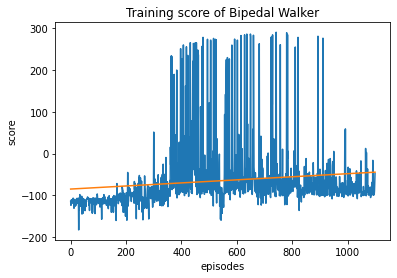

Episode 1110 scores -72.46882447215215
Episode 1120 scores -63.688417117760835


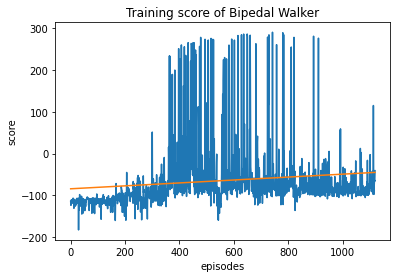

Episode 1130 scores -51.9574314196863
Episode 1140 scores -29.351321384252184


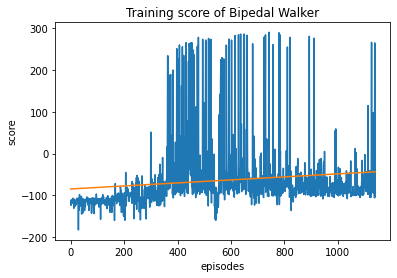

Episode 1150 scores 37.89980117727658
Episode 1160 scores 18.481443835624933


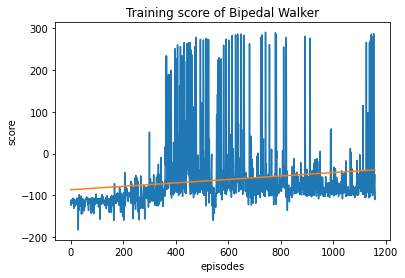

Episode 1170 scores -56.44906206984001
Episode 1180 scores -74.83754470240676


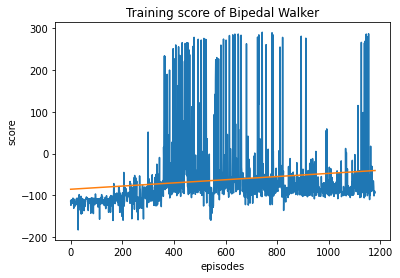

Episode 1190 scores -82.7444020075341
Episode 1200 scores -80.79471698919356


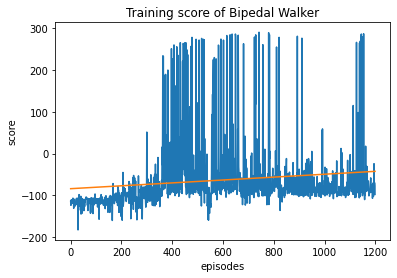

Episode 1210 scores -78.61579382494926
Episode 1220 scores -78.28438155186019


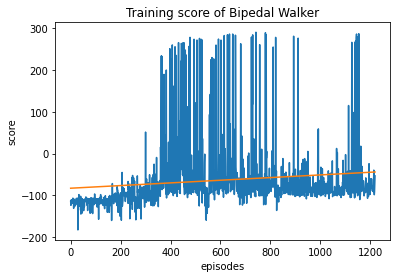

Episode 1230 scores -73.49927572544875
Episode 1240 scores -78.18246718939496


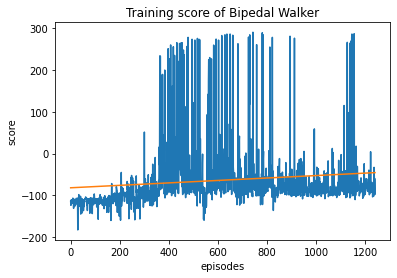

Episode 1250 scores -82.33834100671599
Episode 1260 scores -83.11206506696122


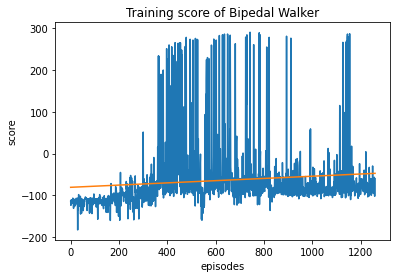

Episode 1270 scores -80.65561010066783
Episode 1280 scores -70.64104199351942


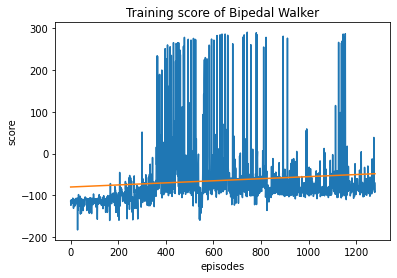

Episode 1290 scores -71.62335771604214
Episode 1300 scores -77.50205537292527


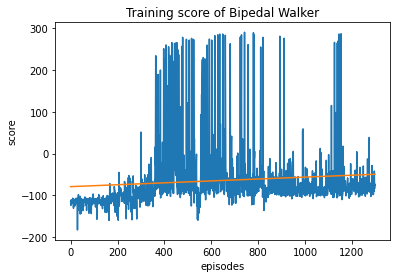

Episode 1310 scores -64.9748774863552
Episode 1320 scores -71.70287532602316


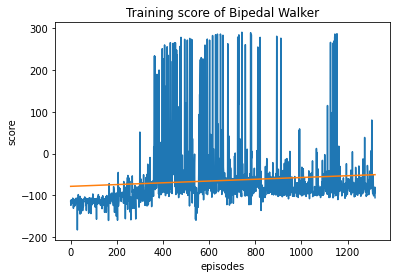

Episode 1330 scores -83.27560821060752
Episode 1340 scores -72.89508286044587


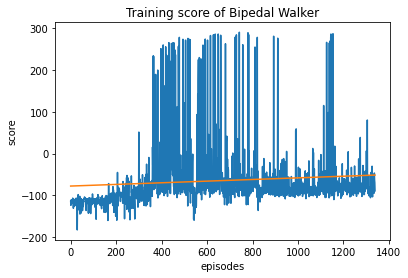

Episode 1350 scores -78.36066757284517
Episode 1360 scores -87.19183919641554


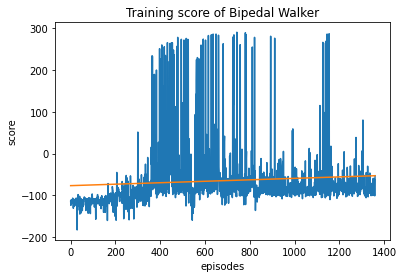

Episode 1370 scores -80.93719108221667
Episode 1380 scores -76.31668355934202


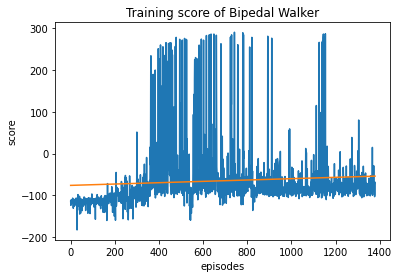

Episode 1390 scores -79.14552341677481
Episode 1400 scores -54.48257217890124


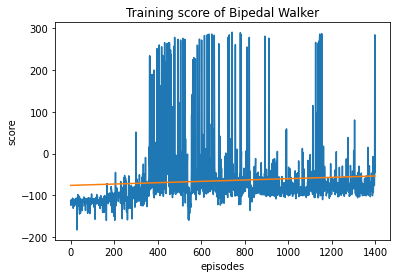

Episode 1410 scores -45.97309628779451
Episode 1420 scores -76.82457316661632


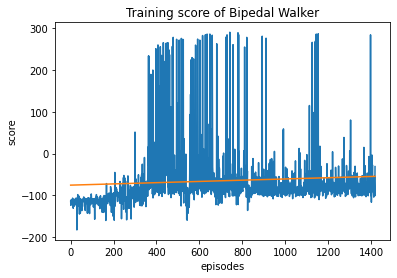

Episode 1430 scores -89.20860099807912
Episode 1440 scores -85.01780698635439


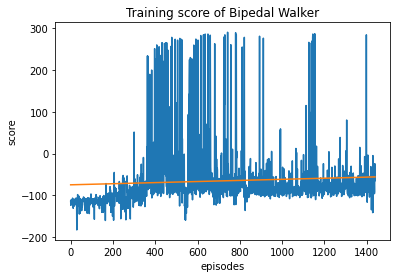

Episode 1450 scores -80.22313294180806
Episode 1460 scores -80.94307355478662


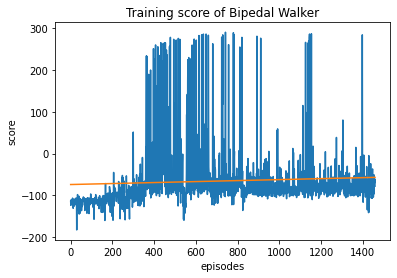

Episode 1470 scores -78.26084837552962
Episode 1480 scores -79.25965597737114


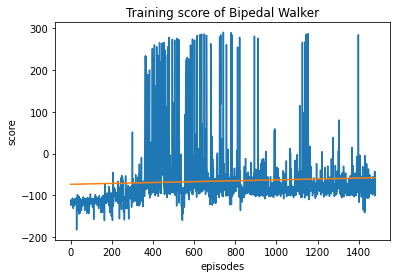

Episode 1490 scores -77.70131721232381
Episode 1500 scores -77.4083954807176


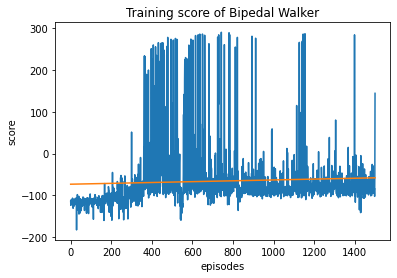

Episode 1510 scores -40.41764204317939
Episode 1520 scores -28.516791911335268


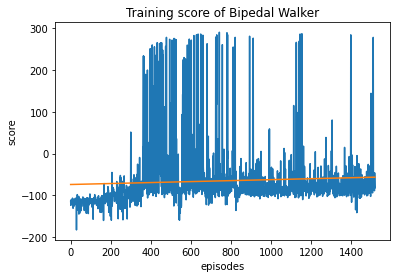

Episode 1530 scores -41.78613060884973
Episode 1540 scores -64.85291241193431


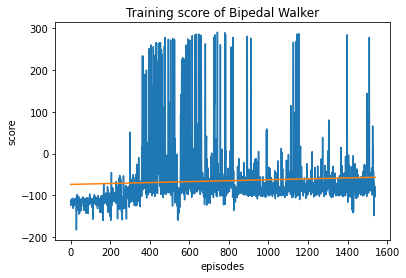

Episode 1550 scores -80.3079193810817
Episode 1560 scores -59.492420548648035


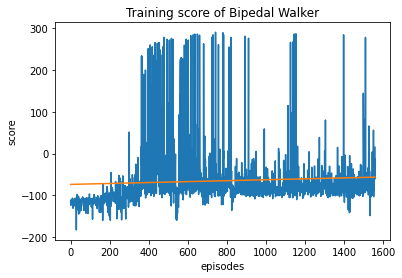

Episode 1570 scores -58.77475178860503
Episode 1580 scores -71.3339939331795


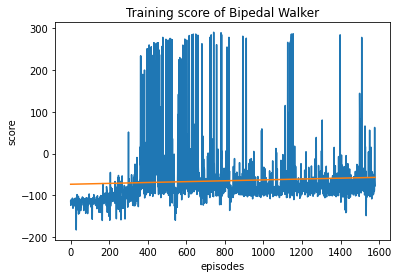

Episode 1590 scores -73.1625169331159
Episode 1600 scores -66.35461162283009


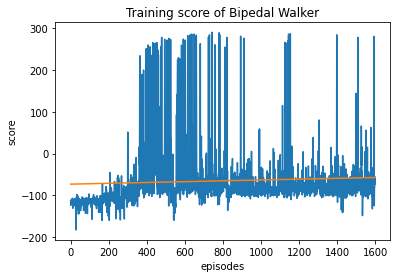

Episode 1610 scores -67.98920921694413
Episode 1620 scores -95.06360930308442


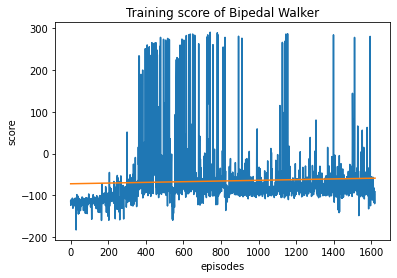

Episode 1630 scores -95.3106206691432
Episode 1640 scores -84.51063934476765


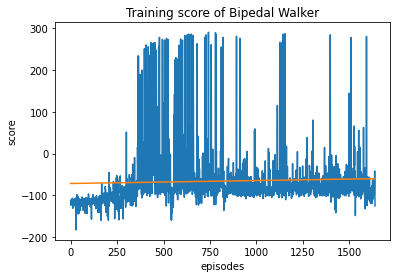

Episode 1650 scores -82.29945467260615
Episode 1660 scores -95.09965904399243


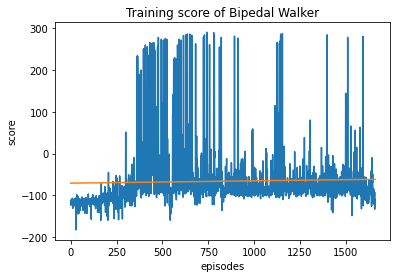

Episode 1670 scores -107.95264586622723
Episode 1680 scores -107.35018550217579


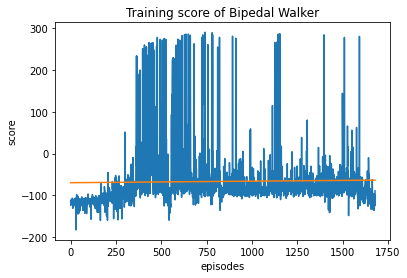

Episode 1690 scores -102.59194566544608
Episode 1700 scores -95.76543656993644


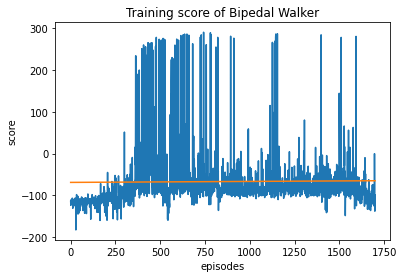

Episode 1710 scores -94.26647934002267
Episode 1720 scores -104.42949989391354


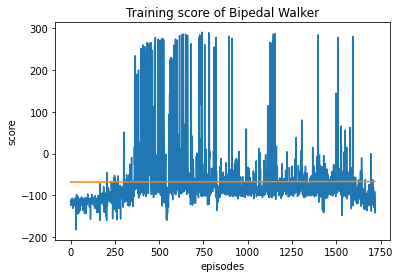

Episode 1730 scores -111.8358482785953
Episode 1740 scores -108.3295286363329


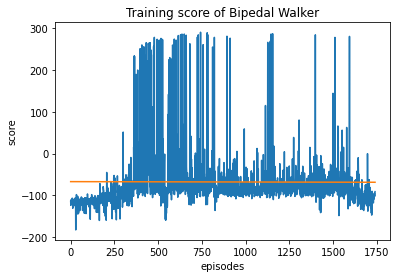

Episode 1750 scores -96.8178736743215
Episode 1760 scores -95.42909722683146


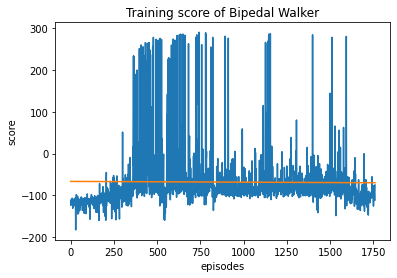

Episode 1770 scores -94.80658478956323
Episode 1780 scores -91.76608176262613


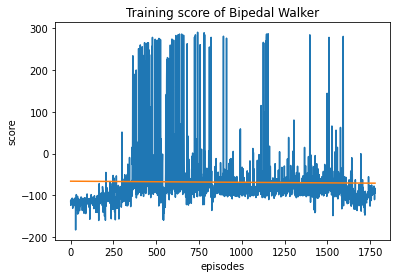

Episode 1790 scores -90.72148660964001
Episode 1800 scores -84.53496063607065


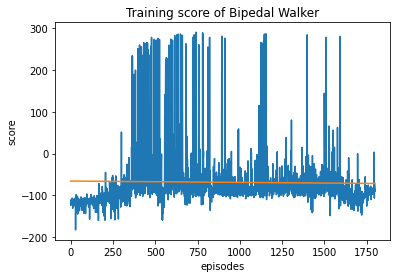

Episode 1810 scores -84.82936968744403
Episode 1820 scores -90.07376564158054


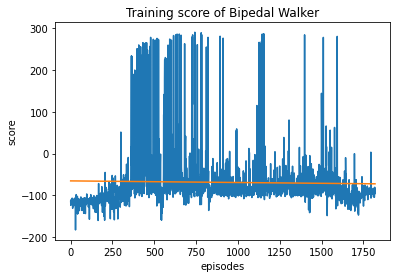

Episode 1830 scores -87.99542026478883
Episode 1840 scores -86.31014514072022


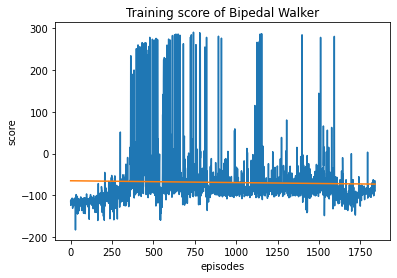

Episode 1850 scores -83.07966610405522
Episode 1860 scores -75.78868211295254


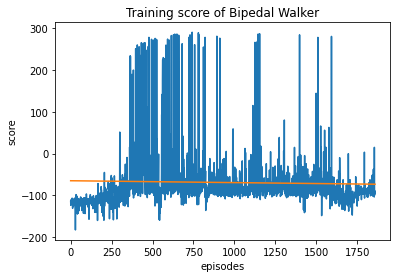

Episode 1870 scores -75.94776510704455
Episode 1880 scores -50.709491866297014


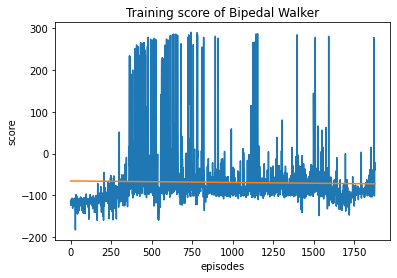

Episode 1890 scores -41.80606669986203
Episode 1900 scores -69.27841512749451


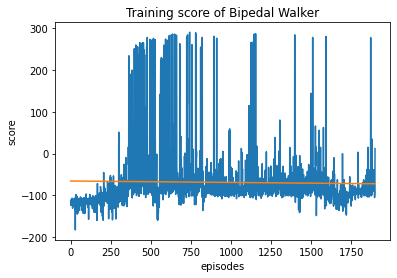

Episode 1910 scores -68.64893431532651
Episode 1920 scores -69.55819614163923


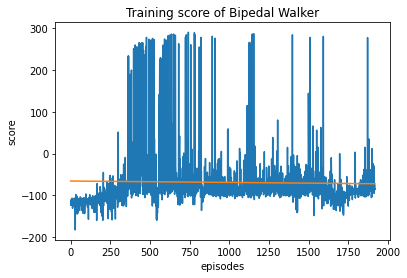

Episode 1930 scores -73.11138129257331
Episode 1940 scores -80.95014026349844


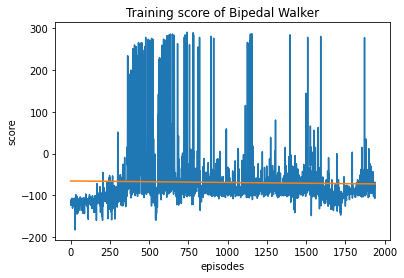

Episode 1950 scores -89.02032067510135
Episode 1960 scores -76.46622121742823


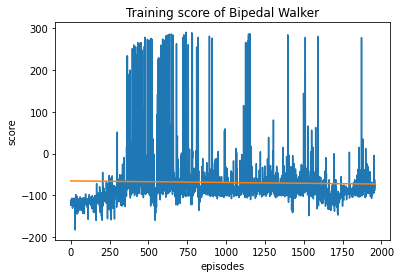

Episode 1970 scores -71.47457629225227
Episode 1980 scores -67.01231061874262


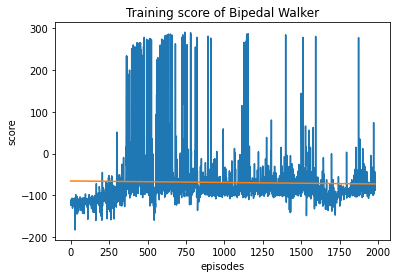

Episode 1990 scores -45.91326672864236
Episode 2000 scores -63.8925730938988


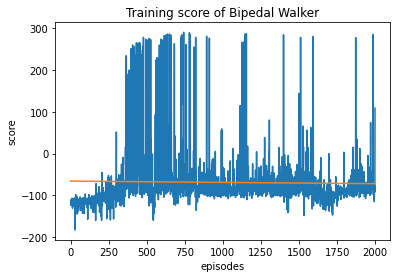

The algorithm has taken 8661.315890789032 to train itself!


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
env = gym.make('BipedalWalker-v3')

Trainer = TD3Agent(env, device)
Trainer.learn()

In [ ]:
import os
PATH = '/content/drive/MyDrive/RL_Team/Bipedal/'
torch.save(Trainer.Actor_Net.state_dict(), os.path.join(PATH, 'actor512.pt'))
torch.save(Trainer.Critic1_Net.state_dict(), os.path.join(PATH, 'critic_1512.pt'))
torch.save(Trainer.Critic2_Net.state_dict(), os.path.join(PATH, 'critic_2512.pt'))